In [21]:
# system imports 
import sys

# library imports 
import pandas as pd 
import matplotlib.pyplot as plt
import json
from datetime import datetime

# codebase imports 
from src.util.tennis.rating import Tennis as Player,get_rating
from src.v1.rating_elo.elo import Elo 
from src.util.ufuncs import date_parser, parse_score

#load files 
def load_data(fname):
    matches = pd.read_csv(fname)
    # filter dataset 
    matches_dropset = ['tourney_name', 'surface', 'draw_size', 'winner_seed', 'winner_entry',
        'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_seed', 'loser_entry', 'loser_hand', 'loser_ht', 
        'loser_ioc', 'loser_age', 'winner_rank_points', 'loser_rank_points', 'round','minutes', 'w_ace', 'w_df', 
        'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
        'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank']
    try:
        matches.drop(matches_dropset,inplace=True,axis=1)
    except Exception as e:
        print("Keys not found")


    md = matches.to_dict()
    data = {}
    for i in md['tourney_id'].keys():
        data[md['tourney_date'][i]*1000 + md['match_num'][i]] = md
    dataset = pd.DataFrame.from_dict(md)
    return dataset

def evaluateData(dataset,rformat='matchwise'):
    players = {}
    prat = {}
    plerr = {}
    plerr_time = {}
    eloObj = Elo()
    name_id = {}
    prat_time = {}
    for i in range(dataset.shape[0]):
        pdone = int(100*i/dataset.shape[0])
        print('\r',pdone,end=' ')
        print('\r[',pdone*'=',(100-pdone)*'-',']',pdone,'\%',sep='',end='')
        mtch = dataset.loc[i]
        if mtch['tourney_level'] != 'A':
            continue
        name_id[mtch['winner_name']] = mtch['winner_id']
        if mtch['winner_name'] not in players.keys():
            players[mtch['winner_name']] = Player(mtch['winner_id'],mtch['winner_name'])
            prat[mtch['winner_name']] = [1500]
            prat_time[mtch['winner_name']] = {}
            plerr[mtch['winner_name']] = [0]
            plerr_time[mtch['winner_name']] = {}
        if mtch['loser_name'] not in players.keys():
            players[mtch['loser_name']] = Player(mtch['loser_id'],mtch['loser_name'])
            prat[mtch['loser_name']] = [1500]
            prat_time[mtch['loser_name']] = {}
            plerr[mtch['loser_name']] = [0]
            plerr_time[mtch['loser_name']] = {}
        
        # difference in timing...
        dscore = date_parser(mtch['tourney_date'])
        if players[mtch['loser_name']].last_match == -1:
            players[mtch['loser_name']].last_match = dscore
        if players[mtch['winner_name']].last_match == -1:
            players[mtch['winner_name']].last_match = dscore
        k_loser = dscore - players[mtch['loser_name']].last_match
        k_winner = dscore - players[mtch['winner_name']].last_match

        players[mtch['loser_name']].updateTime(dscore)
        players[mtch['winner_name']].updateTime(dscore)
        delta = players[mtch['winner_name']].rating - players[mtch['loser_name']].rating
        # predict result of the match 
        pred = eloObj.predict(delta) # probability of a person with rating ``advantage`` DELTA winning?? 
        try:
            # get result of the match (statistically)
            match_ratings = get_rating(parse_score(mtch['score']))
        except Exception as e:
            # print("Skipped ",mtch)
            continue
        winner_stat = max(match_ratings[0],match_ratings[1])/(float(match_ratings[0]) + match_ratings[1])
        loser_stat = 1 - winner_stat

        plerr[mtch['loser_name']].append(abs(pred - loser_stat))        # might need to change this 
        plerr[mtch['winner_name']].append(abs(1 - pred - winner_stat))  # might need to change this 
        plerr_time[mtch['loser_name']][mtch['tourney_date']] = abs(pred - loser_stat)
        plerr_time[mtch['winner_name']][mtch['tourney_date']] = abs(1 - pred - winner_stat)

        players[mtch['winner_name']].rating = eloObj.elo_rate(players[mtch['winner_name']].rating,delta,winner_stat,k_winner)
        players[mtch['winner_name']].wins +=1 
        players[mtch['loser_name']].rating = eloObj.elo_rate(players[mtch['loser_name']].rating,delta,loser_stat,k_loser)
        players[mtch['loser_name']].lose += 1
        prat[mtch['loser_name']].append(players[mtch['loser_name']].rating)
        prat[mtch['winner_name']].append(players[mtch['winner_name']].rating)
        prat_time[mtch['loser_name']][mtch['tourney_date']] = players[mtch['loser_name']].rating
        prat_time[mtch['winner_name']][mtch['tourney_date']] = players[mtch['winner_name']].rating
    if rformat == 'matchwise': 
        return prat, players, plerr
    elif rformat == 'datewise':
        return prat_time,players,plerr_time
    else:
        print('ERROR: Invalid return format.')
        exit(1)

def display_results(ppl,players,prat,plerr,rformat='matchwise',fname="DF"):
    # print(ppl)
    for i in ppl:
        print(i,players[i].wins,players[i].lose)
        if rformat == 'matchwise':
            plt.plot(range(len(prat[i])),prat[i],label=i)
        elif rformat== 'datewise':
            plt.plot(list(prat[i].keys()),list(prat[i].values()),label=i)
        else:
            print('Error: Invalid plotting format')
            exit(1)
    plt.title('Change in Elo Rating with time')
    plt.xlabel('Number of Matches')
    plt.ylabel('Elo-Rating')
    plt.legend()
    # plt.savefig('./plots/EloChange_'+fname+datetime.now().strftime('%Y_%b_%d_%H_%M_%S'))
    plt.show()
    # cumulative error 
    
    if rformat == 'matchwise':
        for i in ppl:
            # plotPlayer(i)
            nmat = []
            for x in plerr[i]:
                if len(nmat) == 0:
                    nmat.append(x)
                else:
                    nmat.append((x+nmat[-1]*len(nmat))/(len(nmat) + 1))
            plt.plot(range(len(nmat)),nmat,label=i)
    elif rformat == 'datewise':
        for i in ppl:
            nmat = [] 
            for x in plerr[i].keys():
                if len(nmat) == 0:
                    nmat.append(0)
                else:
                    nmat.append((plerr[i][x] + nmat[-1]*len(nmat))/(len(nmat) + 1))
            plt.plot(plerr[i].keys(),nmat,label=i)
    else:
        print('Invalid format')
        exit(1)
    plt.title('Cumulative Error')
    plt.xlabel('Matches')
    plt.ylabel('Error')
    plt.legend()
    # plt.savefig('./plots/CumulativeError_'+fname+datetime.now().strftime('%Y_%b_%d_%H_%M_%S'))
    plt.show()


    # window error  
    window_size = 15 
    if rformat == 'matchwise':
        for i in ppl:
            # plotPlayer(i)
            nmat = []
            for x in range(len(plerr[i])):
                if x < window_size:
                    y = 0
                    ans = 0
                    while y <= x:
                        ans += plerr[i][y]
                        y += 1
                    nmat.append(ans)
                else:
                    ans = 0
                    y = 0 
                    while y < window_size:
                        y += 1
                        ans += plerr[i][x - y]
                    nmat.append(ans)
            plt.plot(range(len(nmat)),nmat,label=i)
    elif rformat == 'datewise':
        for i in ppl:
            nmat = [] 
            itlist = list(plerr[i].keys())
            for x in range(len(itlist)):
                ans = 0
                y = 0 
                if x < window_size:
                    while y <= x:
                        ans += plerr[i][itlist[y]]
                        y += 1
                else:
                    while y < window_size:
                        y += 1
                        ans += plerr[i][itlist[x-y]]
                nmat.append(ans)
            plt.plot(itlist,nmat,label=i)    
    else:
        print('Error: Invalid format')
        exit(1)
    plt.title('Window Error')
    plt.xlabel('Matches')
    plt.ylabel('Error')
    plt.legend()
    # plt.savefig('./plots/WindowError_'+fname+datetime.now().strftime('%Y_%b_%d_%H_%M_%S'))
    plt.show()



In [22]:
    # fname = input('Enter Dataset Filename')
fname = './dataset/atp_matches_till_2022.csv'
dformat = 'datewise'
assert(dformat in ['datewise','matchwise'])
dataset = load_data(fname)
prat, players,plerr = evaluateData(dataset,dformat)


[===================================================================================================-]99\%\%\%\%=========================---------------------------------------------------------------------------]25\%--------------------------------------------------------------]38\%============================================--------------------------------------------------------]44\%===================================================-------------------------------------------------]51\%]55\% 74 ------------------]82\%84\%\%\%

Roger Federer 254 45
Rafael Nadal 222 36
Daniil Medvedev 99 31
Novak Djokovic 173 23
Andrey Rublev 89 37


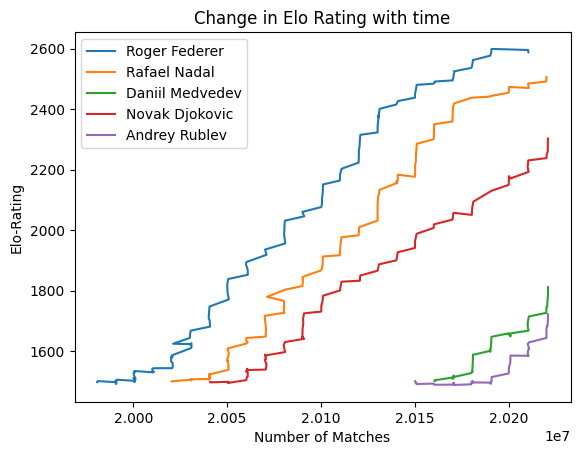

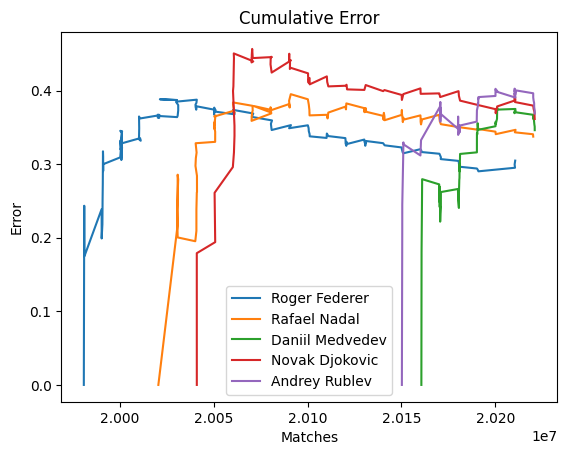

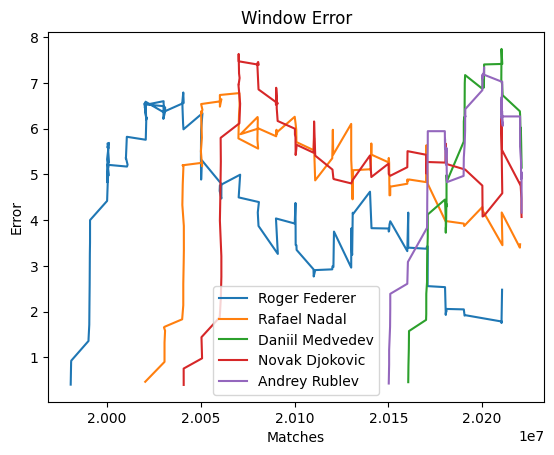

In [27]:
import json 
fin = input('Enter input filename')
fn = list(json.load(open(fin,'r'))['inputs'])
display_results(fn,players,prat,plerr,dformat)


In [ ]:
json.load(open('./inputs/in1.json','r'))